# Smoothed Particle Hydrodynamics: Self-gravitating cloud collapse

In this problem we have an homogeneous spherical cloud of gas in space in which we have induced a gravitational collapse. This makes that the density is higher in the core and decreases with the radius of the cloud. 
We are going to calculate here the density of each fluid element using the Smoothed Particle Hydrodynamics technique.

First, we import the necessary files:
(execute the cell, click on the link that shows up and copy-paste the code in the box)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import time
import math

from numpy.random import seed
from numpy.random import rand
from numba import njit,prange,cuda

from matplotlib import pyplot as plt
import matplotlib

We now define this helper function to compute the coefficients of the SPH interpolation kernel:

In [3]:
@njit
def compute_3d_k(n):
    b0 = 2.7012593e-2;
    b1 = 2.0410827e-2;
    b2 = 3.7451957e-3;
    b3 = 4.7013839e-2;

    return b0 + b1 * math.sqrt(n) + b2 * n + b3 * math.sqrt(n * n * n);

Here we define the SPH interpolation kernel, which is a *sinc* function:

In [4]:
# This is the SPH Kernel
@njit
def wharmonic(v):
    if (v == 0.0):
        return 1.0;
    Pv = (math.pi / 2.0) * v;
    return math.sin(Pv) / Pv;

We load the initial data containing the fluid elements (SPH particles) spatial distribution, their corresponding smoothing length (h), and their associated mass. We also load how many neighboring particles each particle has and the identifying indexes of those neighbors:

In [5]:
# Reads the input file
# Calls compute_density
# Write the result in out.txt
# f = open('/scicore/home/scicore/GROUP/gpu_course/pdata')
f = open('/content/drive/MyDrive/GPU_Course_2021/pdata')

#hello

if f.closed == True:
    print("Error opening file pdata")

n = int(np.fromfile(f, dtype=np.int64, count=1))
ngmax = int(np.fromfile(f, dtype=np.int64, count=1))

x = np.fromfile(f, dtype=np.double, count=n)
y = np.fromfile(f, dtype=np.double, count=n)
z = np.fromfile(f, dtype=np.double, count=n)
h = np.fromfile(f, dtype=np.double, count=n)
m = np.fromfile(f, dtype=np.double, count=n)
neighborsCount = np.fromfile(f, dtype=np.int32, count=n)
neighbors = np.fromfile(f, dtype=np.int32, count=n*ngmax)

f.close()

print('We have loaded '+str(n)+' particles! Each particle has '+str(ngmax)+' neighbors.')

We have loaded 1000000 particles! Each particle has 450 neighbors.


Now we implement the density function, which updates the density (ro) of every particle based on their x, y, z coordinates and their smoothing length (or radius) h.

To compute the density of one particle (first loop), we need to iterate over its neighbors (second loop):

In [6]:
# Compute density here
@njit(parallel=True)
def compute_density(n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro):
    K = compute_3d_k(6.0);

    for i in prange(0, n):
        nn = neighborsCount[i];

        roloc = 0.0;

        for pj in range(0, nn):
            j = neighbors[i * ngmax + pj];

            xx = x[i] - x[j];
            yy = y[i] - y[j];
            zz = z[i] - z[j];

            dist = math.sqrt(xx * xx + yy * yy + zz * zz);

            # SPH Kernel
            vloc = wharmonic(dist / h[i]);

            w = K * vloc * vloc * vloc * vloc * vloc * vloc;
            value = w / (h[i] * h[i] * h[i]);

            roloc = roloc + value * m[j];

        ro[i] = roloc + m[i] * K / (h[i] * h[i] * h[i]);

ro = np.empty([n], dtype=np.double)
start = time.time()
compute_density(n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro);
end = time.time()
print('Elapsed time: ', end - start)

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Elapsed time:  12.476109743118286


## CUDA implementation

Now we present the CUDA implementation of this calculation. As seen in previous examples, we will map the outer loop to a CUDA grid of threads (here we define a 1D grid, so this is more like a CUDA vector of threads!).

We have **1 million particles**. We create **1 million CUDA threads**. Each thread will compute the density of one particle.

Each thread must first find the *id* of the particle it will compute. Each thread has a *thread id* and a *block id* (remember that there are multiple threads per block). We use this to get the index of the particle!

Forget the 'offset' variable for now, it is set to zero.

In [7]:
# Compute density here
@cuda.jit
def compute_density_cuda(n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro, K, offset=0):
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    i = offset + tx + ty * bw
    
    if i < n:
        nn = neighborsCount[i];

        roloc = 0.0;

        for pj in range(0, nn):
            j = neighbors[(i-offset) * ngmax + pj];

            xx = x[i] - x[j];
            yy = y[i] - y[j];
            zz = z[i] - z[j];

            dist = math.sqrt(xx * xx + yy * yy + zz * zz);

            # SPH Kernel
            vloc = wharmonic(dist / h[i]);

            w = K * vloc * vloc * vloc * vloc * vloc * vloc;
            value = w / (h[i] * h[i] * h[i]);

            roloc = roloc + value * m[j];

        ro[i] = roloc + m[i] * K / (h[i] * h[i] * h[i]);

ro = np.empty([n], dtype=np.double)
K = compute_3d_k(6.0)
TPB = 32
blockspergrid = (n + (TPB - 1)) // TPB
start = time.time()
compute_density_cuda[blockspergrid, TPB](n, ngmax, neighbors, neighborsCount, x, y, z, h, m, ro, K, 0)
end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  1.7857508659362793


## Overlapping communications and computations

The main bottleneck here is the transfer of the data to the GPU memory. We are transferring ~2GB of data in total (x, y, z, h, m, ro, neighbors, neighborsCount). The neighbors array is particularly big: it contains the list of neighbors of every particle (1,000,000 * 450 integer values).

In our naive implementation, Numba is sending our arrays to the GPU automatically. This makes things easy for us, but this is not optimal. The kernel will only start once all the data has been transferred.

This is a very common issue with GPU codes! Fortunately, we can change this.  In this section, we are going to manually specify the data transfers (which C/C++/Fortran users would have to do anyway).

We are also going one step further. Instead of sending the entire neighbors array at once, we will divide it into smaller chunks. We will start by sending the neighbors of the first X particles, and then immediately start computing the first X particles, without having to wait for all the neighbors to arrive to the GPU. Then, **while** the first X particles are being computed, we will send the neighbors needed for the next X particles... And this allows to overlap data transfers and computations!

### Cuda streams

According to the CUDA programming guide, a stream is a sequence of commands that execute in order. Different streams, on the other hand, may execute their commands out of order with respect to one another or concurrently.

By default, CUDA uses only one stream (the default stream). So here, we are going to create and use a different stream for each chunk (one per iteration). Each stream will do two things:
1.   Send the appropriate chunk of neighbors to the GPU 
2.   Start a new CUDA kernel to compute the corresponding chunk of particles

In the following example, we divide our 1 million particles into 16 chunks of 62500 particles. Note that the kernel call is not blocking. So as soon as the kernel call is issued, the code will jump to the next iteration, and immediately start transferring the next chunk of data.

In [8]:
ro = np.empty([n], dtype=np.double)
K = compute_3d_k(6.0)

nChunks = 16
start = time.time()

# We manually send the following whole arrays to the GPU
dneighborsCount = cuda.to_device(neighborsCount)
dx = cuda.to_device(x)
dy = cuda.to_device(y)
dz = cuda.to_device(z)
dh = cuda.to_device(h)
dm = cuda.to_device(m)
dro = cuda.to_device(ro)

# We divide the computation in nChunks
for i in range(0,nChunks):
    chunkSize = int(n / nChunks)
    offset = chunkSize * i

    # We create a new stream
    stream = cuda.stream()
    
    b = i * chunkSize * ngmax
    e = (i+1)*chunkSize*ngmax
    # we manually send the neighbors needed for chunk i, which start at particle b and ends at particle e
    dneighbors = cuda.to_device(neighbors[b:e], stream=stream)
    
    TPB = 32
    blockspergrid = (chunkSize + (TPB - 1)) // TPB
    compute_density_cuda[blockspergrid, TPB, stream](n, ngmax, dneighbors, dneighborsCount, dx, dy, dz, dh, dm, dro, K, offset)
    
ro = dro.copy_to_host()

end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  0.5502488613128662


## Checking the result

Now we can plot the particle distribution and the density profile. For the first, in order to see the interior od the cloud, we will make a cut though a plane located at Z=0, and color each particle with its density.
For the second, we simply plot the density in function of the radius of each particle, measure from the center of the cloud.

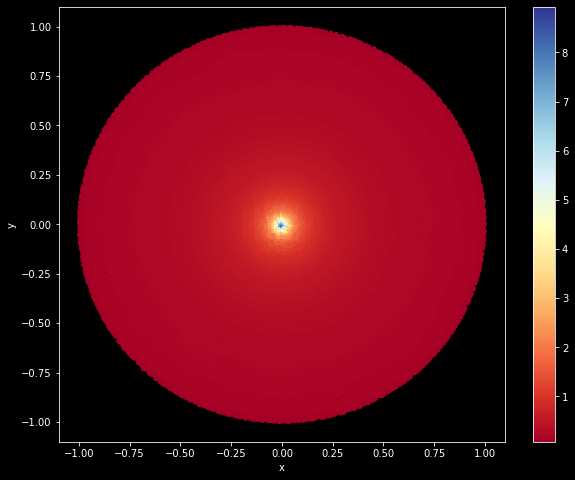

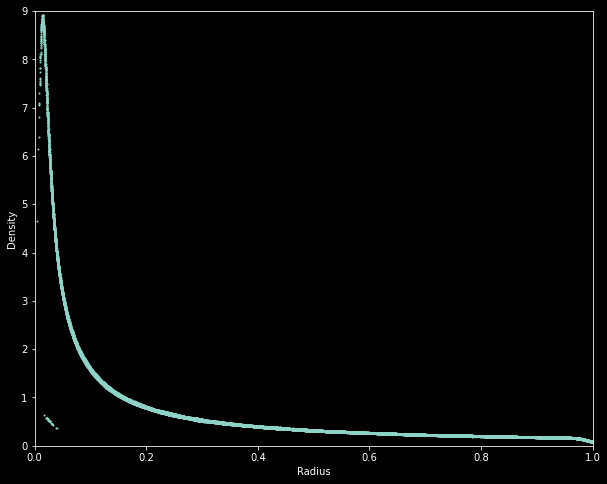

In [9]:
mask = abs(z / h) < 2.0

cm = plt.cm.get_cmap('RdYlBu')

plt.style.use('dark_background')

plt.figure(figsize=(10,8))
# Plot 2D projection a middle cut
sc = plt.scatter(x[mask], y[mask], c=ro[mask], s=10.0, label="Sedov", vmin=min(ro[mask]), vmax=max(ro[mask]), cmap=cm)
plt.colorbar(sc)
plt.xlabel('x')
plt.ylabel('y')
plt.draw()

radius = np.array([math.sqrt(x[i]*x[i]+y[i]*y[i]+z[i]*z[i]) for i in range(len(x))])

plt.figure(figsize=(10,8))
plt.scatter(radius[mask], ro[mask], s=1.0)
plt.xlabel('Radius')
plt.ylabel('Density')
plt.ylim([0,9])
plt.xlim([0,1])
plt.draw()

## Profiling and Monitoring

Finally, we will spend some time profiling and analysing the different versions. We start with the latest version of the code and we set `nChunks=1` and `TPB=32`.

`nvprof -o async_1_32.nvvp python sph_numba_cuda.py`

![picture](https://drive.google.com/uc?id=1SNU8-IcK7Z-oXqlAL265GfOl6ws0guPy)

Then, we do the same thing but we set `nChunks=10`.

`nvprof -o async_10_32.nvvp python sph_numba_cuda.py`

![picture](https://drive.google.com/uc?id=1s28uU6sVBBUWHOnFEr0OlZNlDBvmt9Nl)

As you can see, we do have overlapping of computations and communications (yellow and blue). Note that computations are always slightly shorter than memory transfers.

Nvvp has more advanced analysis tools, but we need to get more data. We can ask nvprof to analyze more metrics as follows:

`nvprof --analysis-metrics -o async_10_32_withmetrics.nvvp python sph_numba_cuda.py`

In Nvvp, in the analysis tab, do the following:
*   Click 'Examine GPU usage'
*   Click 'Examine individual kernels'
*   Click the kernel you would like to analyze
*   Click 'Peform analysis'

Here you have several choices that will each give you useful informations about your kernel and possible bottlenecks.

*   Click 'Perform latency analysis'
*   Click 'Examine occupancy'

![picture](https://drive.google.com/uc?id=1G3U9EW5zstL-mhBvJql4SE6cg2FAPSZW)

### Optimizing occupancy

CUDA groups adjacent threads within a block into warps. A warp is considered active from the time its threads begin executing to the time when all threads in the warp have exited from the kernel. There is a maximum number of warps which can be concurrently active on a Streaming Multiprocessor (SM), as listed in the Programming Guide's table of compute capabilities.

Occupancy is defined as the ratio of active warps on an SM to the maximum number of active warps supported by the SM. Occupancy varies over time as warps begin and end, and can be different for each SM.

Here, we get an 'achieved occupancy' of 47.7%. Now look at the three bottom graphs. In the first one, CUDA tells us the number of active warps we get depending on the number of threads per block. We are currently at 32. According to this plot, we could use 40 threads per block and get 40 active warps, out of 64. So lets try this!

Set `TPB=40` in the code and run again:

`nvprof --analysis-metrics -o async_10_40_withmetrics.nvvp python sph_numba_cuda.py`

![picture](https://drive.google.com/uc?id=11ZdbjNkpUs6EogF47FthriKy_vbSVwu2)

As you can see, the occuypancy jumped to 59%! 

So can we further improve the occupancy? According to the middle plot, we would need to use less registers per thread. This is ucrrently not something we can change using numba. We could force cuda to use less registers in C/C++, but the resulting code will most likely be slower anyway.

